In [39]:
import os  
import json

json_data = json.load(open("cred.json")) # this or specify manually

os.environ["MLFLOW_TRACKING_USERNAME"] = json_data["MLFLOW_TRACKING_USERNAME"]
os.environ["MLFLOW_TRACKING_PASSWORD"] = json_data["MLFLOW_TRACKING_PASSWORD"]
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = json_data["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"]
os.environ["AWS_DEFAULT_REGION"] = json_data["AWS_DEFAULT_REGION"]
os.environ["AWS_REGION"] = json_data["AWS_REGION"]
os.environ["AWS_ACCESS_KEY_ID"] = json_data["AWS_ACCESS_KEY_ID"]
os.environ["AWS_SECRET_ACCESS_KEY"] = json_data["AWS_SECRET_ACCESS_KEY"]
os.environ["MLFLOW_S3_ENDPOINT_URL"] = json_data["MLFLOW_S3_ENDPOINT_URL"]
os.environ["MLFLOW_TRACKING_URI"] = json_data["MLFLOW_TRACKING_URI"]


from mlflow import MlflowClient
import mlflow

In [40]:
# adapted from https://christophermayes.github.io/Xopt/examples/single_objective_bayes_opt/custom_model/

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from xopt.vocs import VOCS

my_vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)

Iteration 0, loss = 1.3519446849822998, clean_loss = 0.8149316310882568
Iteration 100, loss = 0.7719717025756836, clean_loss = 0.2512171268463135
Iteration 200, loss = 0.5863481163978577, clean_loss = 0.03919851779937744
Iteration 300, loss = 0.5817224383354187, clean_loss = 0.033556386828422546
Iteration 400, loss = 0.58150714635849, clean_loss = 0.033280763775110245
Iteration 500, loss = 0.5814952850341797, clean_loss = 0.03330016881227493
Iteration 600, loss = 0.5814950466156006, clean_loss = 0.0332760214805603
Iteration 700, loss = 0.5814952254295349, clean_loss = 0.033291786909103394
Iteration 800, loss = 0.5814946889877319, clean_loss = 0.03328472748398781
Iteration 900, loss = 0.5814943313598633, clean_loss = 0.0332728810608387


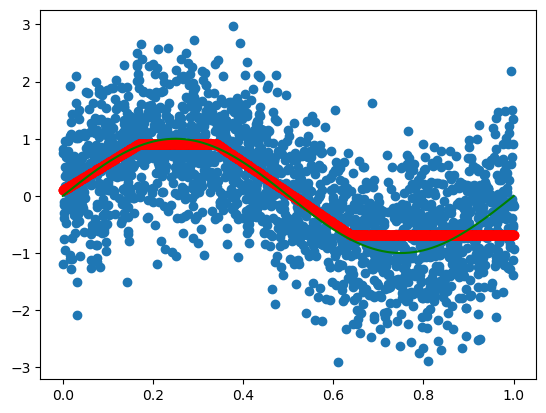

2024/04/24 16:08:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/04/24 16:08:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/04/24 16:08:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/24 16:08:17 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


KeyboardInterrupt: 

In [84]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

train_X = torch.rand(2000, 1)
train_Y = torch.sin(2 * 3.14 * train_X) + 0.75 * torch.randn_like(train_X) # we make it interesting with very noisy data
train_Y_clean = torch.sin(2 * 3.14 * train_X)


class ConstraintPrior(torch.nn.Module):
    def __init__(self, width = 5):
        super().__init__()
        # simple relu network
        self.fc1 = torch.nn.Linear(1, width)
        self.fc2 = torch.nn.ReLU() # GELU is a better choice here but we want some bad results
        self.fc3 = torch.nn.Linear(width, width)
        self.fc4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(width, 1)

        # weight initializations
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        torch.nn.init.xavier_normal_(self.fc5.weight)

        # random bias initializations
        torch.nn.init.normal_(self.fc1.bias)
        torch.nn.init.normal_(self.fc3.bias)
        torch.nn.init.normal_(self.fc5.bias)
    def forward(self, X, train=False):
        
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.fc4(X)
        X = self.fc5(X)
        if train: 
            return X # retiurn [len(X), 1]
        else:
            return torch.squeeze(X)
            
            
        


model = ConstraintPrior(width = 5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

client = MlflowClient()


loss_arr = []
val_loss_arr = []


for i in range(1000):  # Increase the number of iterations for better convergence
    optimizer.zero_grad()
    y_pred = model(train_X , train=True)
    loss = F.mse_loss(y_pred, train_Y)
    loss.backward()
    optimizer.step()
    
    clean_loss = F.mse_loss(y_pred, train_Y_clean)
    
    loss_arr.append(loss.item())
    val_loss_arr.append(clean_loss.item())
    
    
    if i % 100 == 0:
        print(f'Iteration {i}, loss = {loss.item()}, clean_loss = {clean_loss.item()}')

plt.scatter(train_X, train_Y)
plt.scatter(train_X, model(train_X).detach(), color='red')
# plot true sine
train_X_sorted, indices = torch.sort(train_X, 0)
plt.plot(train_X_sorted, torch.sin(2 * 3.14 * train_X_sorted), color='green')
plt.show()

# we are logging after the fact due to mlflow slowing down training

with mlflow.start_run() as run: 
    
    mlflow.log_param("lr", 0.01)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss", "MSELoss")
    mlflow.log_param("width", 5)
    
    for i in range(1000):
        # log only every 100th step
        # mlflow.log_metric("loss", loss_arr[i], step=i)
        # mlflow.log_metric("clean_loss", val_loss_arr[i], step=i)
        if i % 100 == 0:
            mlflow.log_metric("loss", loss_arr[i], step=i)
            mlflow.log_metric("clean_loss", val_loss_arr[i], step=i)
   

    # log model 
    result = mlflow.pytorch.log_model(pytorch_model = model, artifact_path="model")        

In [78]:
client = MlflowClient()


result_torch = client.create_model_version(
    name="constraint_prior",
    source=result.model_uri,
    run_id=result.run_id,
)

client.set_registered_model_alias("constraint_prior", "champion", result_torch.version)

2024/04/24 16:07:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: constraint_prior, version 13


2024/04/24 16:07:01 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


<class 'type'>


<Axes: >

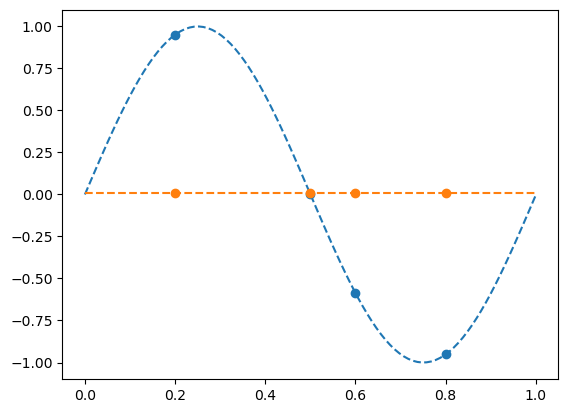

In [79]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

# originally we define a custom function here, however we want to make use of mlfow to retrieve a registered torch model
# def c(x):
#     #
# now say this is a different notebook to the one above
# get the model from mlflow
client = MlflowClient()
model_mlf = mlflow.pytorch.load_model("models:/constraint_prior@champion")
print(type)

def c(x):
    X = x.reshape(len(x), 1)
    return model_mlf(X).squeeze(-1).detach()


test_x = torch.linspace(*torch.tensor(my_vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6, 0.8))
train_y = y(train_x)
train_c = c(train_x)

training_data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

In [80]:
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor


gp_constructor = StandardModelConstructor(
    mean_modules={"c": model_mlf},)
generator = ExpectedImprovementGenerator(
    vocs=my_vocs, gp_constructor=gp_constructor,
)

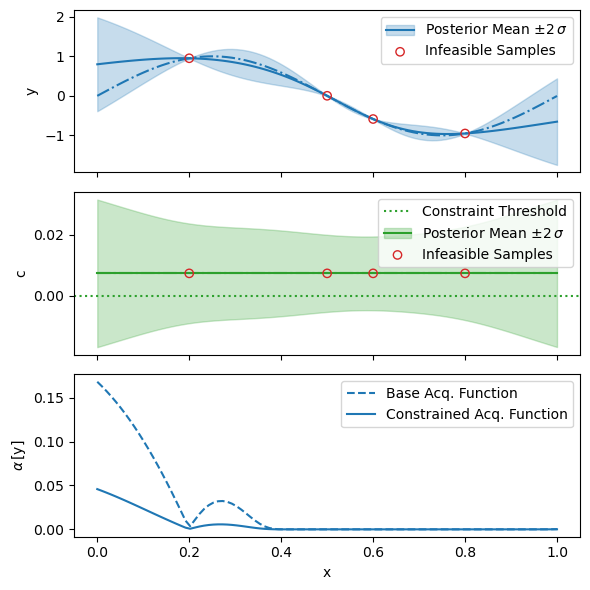

In [81]:
# view custom model from data
generator.add_data(training_data)
model = generator.train_model()

fig, ax = generator.visualize_model(n_grid=len(test_x))
# plot ground truth
ax[0].plot(test_x, y(test_x), "C0-.")
ax[1].plot(test_x, c(test_x), "C2-.");

(<Figure size 600x600 with 3 Axes>,
 array([<Axes: ylabel='y'>, <Axes: ylabel='c'>,
        <Axes: xlabel='x', ylabel='$\\alpha\\,$[y]'>], dtype=object))

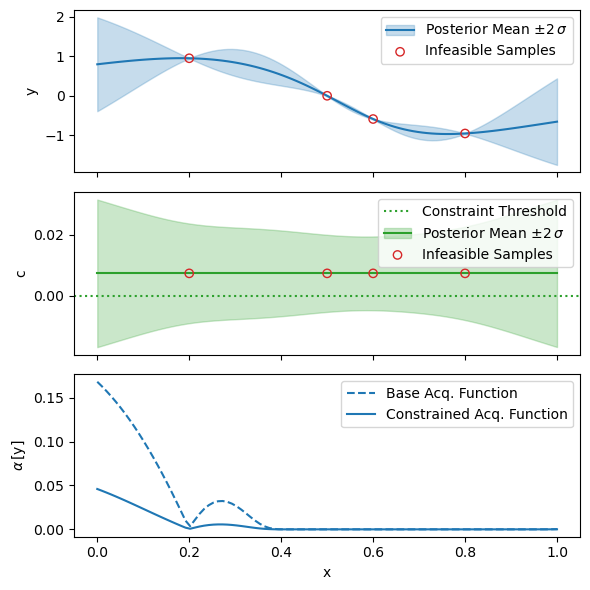

In [82]:
generator.visualize_model(n_grid=len(test_x))